<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EZyRB-Tutorial-2" data-toc-modified-id="EZyRB-Tutorial-2-1">EZyRB Tutorial 2</a></span><ul class="toc-item"><li><span><a href="#Test-several-frameworks-at-once" data-toc-modified-id="Test-several-frameworks-at-once-1.1">Test several frameworks at once</a></span><ul class="toc-item"><li><span><a href="#Initial-setting" data-toc-modified-id="Initial-setting-1.1.1">Initial setting</a></span></li><li><span><a href="#Comparison-between-different-methods" data-toc-modified-id="Comparison-between-different-methods-1.1.2">Comparison between different methods</a></span></li></ul></li></ul></li></ul></div>

# EZyRB Tutorial 2
## Test several frameworks at once

In this tutorial, we will explain step by step how to use the **EZyRB** library to test different techniques for building the reduced order model. We will compare different methods of dimensionality reduction, interpolation and accuracy assessment.

We consider here a computational fluid dynamics problem described by the (incompressible) Navier Stokes equations.
We will be using the **Navier Stokes Dataset** that contains the output data from a full order flow simulation and can be found on **GitHub** under [Smithers library](https://github.com/mathLab/Smithers).
**Smithers** is developed by **SISSA mathlab** and it contains some useful datasets and a multi-purpose toolbox that inherits functionality from other packages to make the process of dealing with these datasets much easier with more compact coding.

The package can be installed using `python -m pip install smithers -U`, but for a detailed description about installation and usage we refer to original [Github page](https://github.com/mathLab/Smithers/blob/master/README.md).

First of all, we just import the package and instantiate the dataset object.

In [1]:
!pip install -U datasets huggingface_hub fsspec
!pip install git+https://github.com/mathLab/EZyRB.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

In [ ]:
from datasets import load_dataset
data_path = "kshitij-pandey/navier_stokes_datasets"
snapshots_hf = load_dataset(data_path, "snapshots_split", split="train")
param_hf = load_dataset(data_path, "params", split="train")
triangles_hf    = load_dataset(data_path, "triangles", split="train")
coords_hf = load_dataset(data_path, "coords", split="train")
import numpy as np
snapshots = {name: np.array(snapshots_hf[name]) for name in ['vx', 'vy', 'mag(v)', 'p']}
# convert the dict files into numpy

import pandas as pd

def hf_to_numpy(ds):
    return ds.to_pandas().to_numpy()


params = hf_to_numpy(param_hf)
triangles = hf_to_numpy(triangles_hf)
coords = hf_to_numpy(coords_hf)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/26.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.33k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3091 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/681k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2 [00:00<?, ? examples/s]

The `NavierStokesDataset()` class contains the attribute:
- `snapshots`: the matrices of snapshots stored by row (one matrix for any output field)
- `params`: the matrix of corresponding parameters
- `pts_coordinates`: the coordinates of all nodes of the discretize space
- `faces`: the actual topology of the discretize space
- `triang`: the triangulation, useful especially for rendering purposes.

In the details, `snapshots` is a dictionary with the following output of interest:
- **vx:** velocity in the X-direction.
- **vy:** velocity in the Y-direction.
- **mag(v):** velocity magnitude.
- **p:** pressure value.

In total, the dataset contains 500 parametric configurations in a space of 1639 degrees of freedom. In this case, we have just one parameter, which is the velocity (along $x$) we impose at the inlet.

In [3]:
for name in ['vx', 'vy', 'p', 'mag(v)']:
     print('Shape of {:7s} snapshots matrix: {}'.format(name, snapshots[name].shape))

print('Shape of parameters matrix: {}'.format(params.shape))


Shape of vx      snapshots matrix: (500, 1639)
Shape of vy      snapshots matrix: (500, 1639)
Shape of p       snapshots matrix: (500, 1639)
Shape of mag(v)  snapshots matrix: (500, 1639)
Shape of parameters matrix: (500, 1)


### Initial setting

First of all, we import the required packages.

From `EZyRB` we need:
1. The `ROM` class, which performs the model order reduction process.
2. A module such as `Database`, where the matrices of snapshots and parameters are stored.
3. A dimensionality reduction method such as Proper Orthogonal Decomposition `POD` or Auto-Encoder network `AE`.
4. An interpolation method to obtain an approximation for the parametric solution for a new set of parameters such as the Radial Basis Function `RBF`, Gaussian Process Regression `GPR`,  K-Neighbors Regressor `KNeighborsRegressor`,  Radius Neighbors Regressor `RadiusNeighborsRegressor` or Multidimensional Linear Interpolator `Linear`.

We also need to import:
* `numpy:` to handle arrays and matrices we will be working with.
* `torch:` to enable the usage of Neural Networks
* `matplotlib.pyplot:` to handle the plotting environment.
* `matplotlib.tri:` for plotting of the triangular grid.

In [4]:
# Database module
from ezyrb import Database

# Dimensionality reduction methods
from ezyrb import POD, AE

# Approximation/interpolation methods
from ezyrb import RBF, GPR, KNeighborsRegressor, RadiusNeighborsRegressor, Linear, ANN

# Model order reduction calss
from ezyrb import ReducedOrderModel as ROM
import torch
import torch.nn as nn

import matplotlib.tri as mtri
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="Ill-conditioned matrix ")
%matplotlib inline

Before starting with the reduced order model, we visualize some of the snapshots in our dataset.

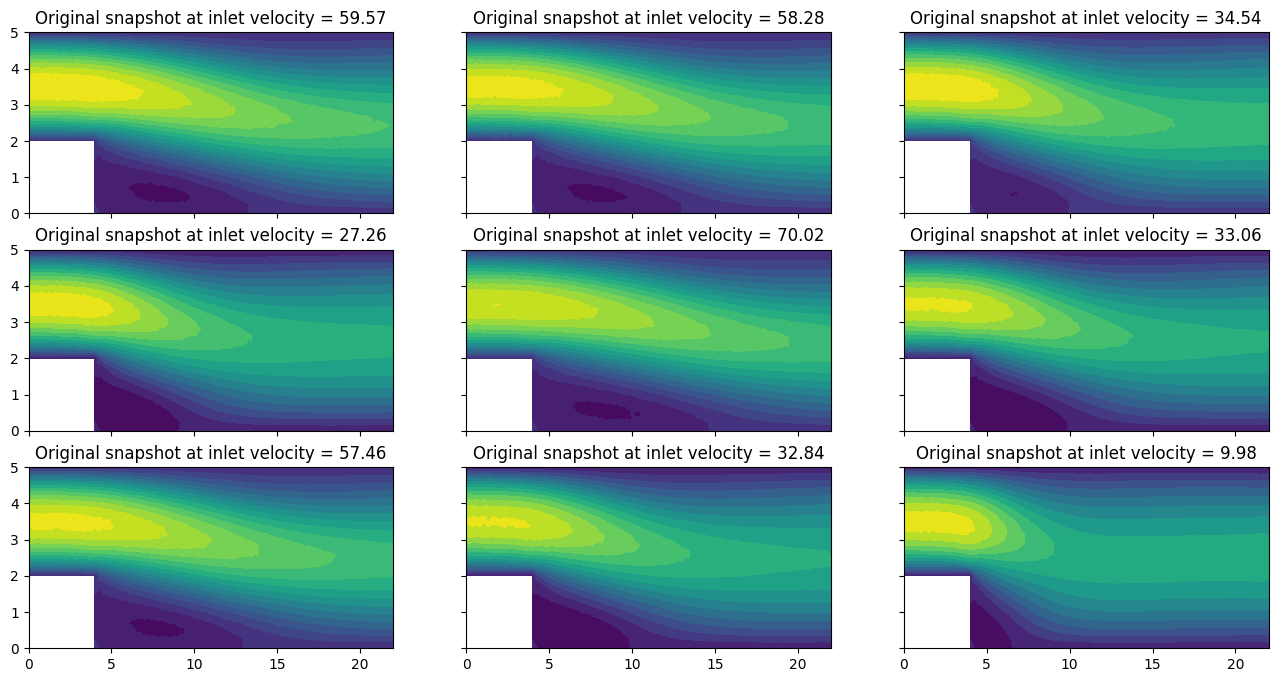

In [5]:
x, y  = coords
from matplotlib.tri import Triangulation
triang = Triangulation(x, y, triangles)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 8), sharey=True, sharex=True)
ax = ax.flatten()
for i in range(9):
    ax[i].tricontourf(triang, snapshots['vx'][i], levels=16)
    ax[i].set_title('Original snapshot at inlet velocity = {}'.format(*params[i].round(2)))

In this step, we perform the model order reduction to obtain a reduced space from the full order space. We refer to [Tutorial 1](https://github.com/mathLab/EZyRB/blob/master/tutorials/tutorial-1.ipynb) for the description of the basic workflow, here we just quickly describe the steps implemented in the next cell.

We start by passing the matrices of the parameters and snapshots to the `Database()` class. It must be said that at this time we create the ROM for the `vx` field. We also instantiate the `POD` and `RBF` object to have a benchmark ROM.

In [6]:
db = Database(params, snapshots['vx'])
rom = ROM(db, POD(), RBF())
rom.fit();

Three lines for a data-driven reduced order model, not bad!

Just to have a visual check that everything is going well, we plot the approximation for new parameters in the range $[1, 80]$.

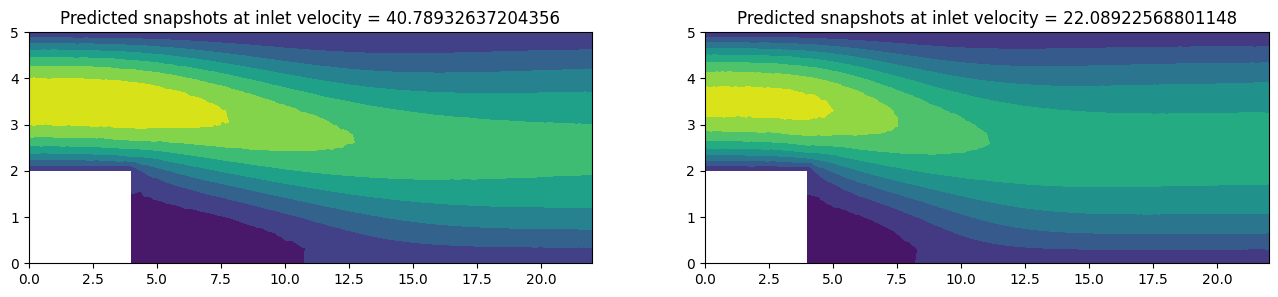

In [7]:
new_params = np.random.uniform(size=(2))*79.+1.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
for i, param in enumerate(new_params):
    ax[i].tricontourf(triang, *rom.predict([param]).snapshots_matrix)
    ax[i].set_title('Predicted snapshots at inlet velocity = {}'.format(param))

We are now calculating the approximation error to see how close is our reduced solution to the full-order solution/simulation using the **k-fold Cross-Validation** strategy by passing the number of splits to the `ReducedOrderModel.kfold_cv_error(n_splits)` method, which operates as follows:

1. Split the dataset (parameters/snapshots) into $k$-number of groups/folds.
2. Use $k-1$ groups to calculate the reduced space and leave one group for testing.
3. Use the approximation/interpolation method to predict each snapshot in the testing group.
4. Calculate the error for each snapshot in the testing group by taking the difference between the predicted and the original snapshot.
5. Average the errors for predicting snapshots of the testing group/fold.
6. Repeat this procedure using different groups for testing and the remaining $k-1$ groups to calculate the reduced space.
7. In the end, we will have $k$-number errors for predicting each group/fold that we can average them to have one value for the error.

In [8]:
errors = rom.kfold_cv_error(n_splits = 5)
print('Average error for each fold:')
for e in errors:
    print('  ',e)
print('\nAverage error = {}'.format(errors.mean()))

Average error for each fold:
   4.945136597864199e-07
   9.86076102695249e-07
   3.894778059089648e-06
   5.3036420477734276e-06
   1.298462179837029e-07

Average error = 2.1617712174656897e-06


Another strategy for calculating the approximation error is called **leave-one-out** by using the  `ReducedOrderModel.loo_error()` method, which is similar to setting the number of folds equal to the number of snapshots (eg. in this case setting `n_splits` = 500) and it operates as follows:
1. Combine all the snapshots except one.
2. Calculate the reduced space.
3. Use the approximation/interpolation method to predict the removed snapshot.
4. Calculate the error by taking the difference between the predicted snapshot and the original removed one.
5. The error vector is obtained by repeating this procedure for each snapshot in the database.

It is worth mentioning that it consumes more time because we have 500 snapshots and the algorithm will perform space order reduction and calculate the approximation error 500 times. For this reason, we commented the next line of code, in order to limit the computational effort needed to run this tutorial. Uncomment it only if you are a really brave person!

In [9]:
# errors = rom.loo_error()

### Comparison between different methods

One of the advantages of the data-driven reduced order modeling is the modular nature of the method. Practically speaking, we need
- a method for reducing the dimensionality of input snapshots;
- a method for approximate the solution manifold;

allowing in principle a large variety of combinations.

The list of implemented **reduction methods** in EZyRB contains:
- `POD`: *proper orthogonal decomposition*
- `AE`: *autoencoder*

while the list of implemented **approximation methods** contains:
- `RBF`: *radial basis function interpolation*
- `GPR`: *gaussian process regression*
- `KNeighborsRegressor`: *k-neighbors regression*
- `RadiusNeighborsRegressor`: *radius neighbors regression*
- `Linear`: *multidimensional linear interpolation*

Moreover, new state-of-the-art methods will arrive, so we invite you to read the [documentation](https://mathlab.github.io/EZyRB/) for the complete list of all the possibilities!

In the next cell, we create two dictionaries with the objects, such that we can easily test everything with simple `for` cycles. **WARNING** since several methods require the solution of an optimization problem (eg. GPR, ANN, AE), the cell may require some minutes to be run.

In [10]:
reductions = {
    'POD': POD('svd',rank=10),
    'AE': AE([200, 100, 10], [10, 100, 200], nn.Tanh(), nn.Tanh(), 10),
}

approximations = {
#    'Linear': Linear(),
    'RBF': RBF(),
    'GPR': GPR(),
    'KNeighbors': KNeighborsRegressor(),
    'RadiusNeighbors':  RadiusNeighborsRegressor(),
    'ANN': ANN([20, 20], nn.Tanh(), 10),
}

header = '{:10s}'.format('')
for name in approximations:
    header += ' {:>15s}'.format(name)

print(header)
for redname, redclass in reductions.items():
    row = '{:10s}'.format(redname)
    for approxname, approxclass in approximations.items():
        rom = ROM(db, redclass, approxclass)
        rom.fit()
        row += ' {:15e}'.format(rom.kfold_cv_error(n_splits=5).mean())

    print(row)


                       RBF             GPR      KNeighbors RadiusNeighbors             ANN
[epoch      1]	9.552292e+04
[epoch     10]	9.546308e+04
[epoch      1]	9.717124e+04
[epoch     10]	9.394288e+04
[epoch      1]	9.390123e+04
[epoch     10]	9.070695e+04
[epoch      1]	9.016239e+04
[epoch     10]	8.747394e+04
[epoch      1]	9.297216e+04
[epoch     10]	9.052832e+04
[epoch      1]	9.303061e+04
[epoch     10]	9.086118e+04
POD           1.204641e-05    2.970147e-05    8.032581e-03    1.091257e-02    9.720516e-01
[epoch      1]	5.825196e+02
[epoch     10]	5.575154e+02
[epoch      1]	5.816525e+02
[epoch     10]	7.542178e+01
[epoch      1]	5.960423e+02
[epoch     10]	7.254456e+01
[epoch      1]	5.821843e+02
[epoch     10]	1.140573e+02
[epoch      1]	5.850476e+02
[epoch     10]	8.712418e+01
[epoch      1]	5.703002e+02
[epoch     10]	9.224741e+01
[epoch      1]	5.838640e+02
[epoch     10]	9.697124e+01
[epoch      1]	5.824384e+02
[epoch     10]	8.382781e+01
[epoch      1]	5.972413e+02
[epoch

In a very compact way, we tested several frameworks - like POD-RBF, POD-GPR, POD-NN -, showing the accuracy reached by any of them.

We can also note that the frameworks that involve neural networks (`AE` and `ANN`) show a very poor precision. This is due to the fact of the limited number of epochs we impose in the learning procedure. You can try to increase the number of epochs as we shown in the next cell in order to obtain better results, at the cost of a longer training phase.

In [11]:
reductions['AE'] = AE([100, 10], [10, 100], nn.ReLU(), nn.ReLU(), 30000)
approximations['ANN'] = ANN([50, 10], nn.ReLU(), 30000)